In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .config("spark.driver.memory", "16g")\
    .getOrCreate()

spark

your 131072x1 screen size is bogus. expect trouble


23/04/15 14:51:59 WARN Utils: Your hostname, HOMELAB resolves to a loopback address: 127.0.1.1; using 192.168.38.216 instead (on interface eth0)
23/04/15 14:51:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/15 14:52:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/04/15 14:52:02 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/04/15 14:52:02 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

from pyspark.sql.functions import col, lit

from common import *

plt.rc('axes', labelsize=18, titlesize=18)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=15)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
PREFIX = "main/ycsb-jitter"

IGNORE_CACHE = False

index_df = from_cache_or_compute(
    f'{PREFIX}/index.parquet',
    lambda: get_index(spark, PREFIX)\
        .withColumn("jitter", F.regexp_extract("prefix", r"jitter(\d+)", 1))\
        .withColumn("config_name", F.regexp_replace("config_name", "\.conf", ""))\
        .toPandas()\
        .convert_dtypes()\
        .astype({
            "wl:hot": "int32",
            "wl:mh": "int32",
            "wl:mp": "int32",
        }),
    ignore_cache=IGNORE_CACHE,
)

index_df

,prefix,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:mh,...,wl:mh_zipf,wl:mp_parts,wl:hot,wl:value_size,wl:mh_homes,wl:writes,wl:nearest,wl:sp_partition,wl:sh_home,jitter
0,file:/home/ctring/data/detock/main/ycsb-jitter...,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,0
1,file:/home/ctring/data/detock/main/ycsb-jitter...,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,10
2,file:/home/ctring/data/detock/main/ycsb-jitter...,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,15
3,file:/home/ctring/data/detock/main/ycsb-jitter...,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,20
4,file:/home/ctring/data/detock/main/ycsb-jitter...,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,25
5,file:/home/ctring/data/detock/main/ycsb-jitter...,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,30
6,file:/home/ctring/data/detock/main/ycsb-jitter...,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,35
7,file:/home/ctring/data/detock/main/ycsb-jitter...,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,40
8,file:/home/ctring/data/detock/main/ycsb-jitter...,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,5
9,file:/home/ctring/data/detock/main/ycsb-jitter...,1.0.1022,ddr_ts,15,2000000,200,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,0


In [4]:
PREFIX_OVERSHOOT10 = "main/ycsb-jitter-overshoot10"

IGNORE_CACHE = False

index_overshoot10_df = from_cache_or_compute(
    f'{PREFIX_OVERSHOOT10}/index.parquet',
    lambda: get_index(spark, PREFIX_OVERSHOOT10)\
        .withColumn("jitter", F.regexp_extract("prefix", r"jitter(\d+)", 1))\
        .withColumn("config_name", F.regexp_replace("config_name", "\.conf", ""))\
        .toPandas()\
        .convert_dtypes()\
        .astype({
            "wl:hot": "int32",
            "wl:mh": "int32",
            "wl:mp": "int32",
        }),
    ignore_cache=IGNORE_CACHE,
)

index_overshoot10_df

,prefix,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:mh,...,wl:mh_zipf,wl:mp_parts,wl:hot,wl:value_size,wl:mh_homes,wl:writes,wl:nearest,wl:sp_partition,wl:sh_home,jitter
0,file:///home/ctring/data/detock/main/ycsb-jitt...,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,0
1,file:///home/ctring/data/detock/main/ycsb-jitt...,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,10
2,file:///home/ctring/data/detock/main/ycsb-jitt...,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,15
3,file:///home/ctring/data/detock/main/ycsb-jitt...,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,20
4,file:///home/ctring/data/detock/main/ycsb-jitt...,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,25
5,file:///home/ctring/data/detock/main/ycsb-jitt...,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,30
6,file:///home/ctring/data/detock/main/ycsb-jitt...,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,35
7,file:///home/ctring/data/detock/main/ycsb-jitt...,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,40
8,file:///home/ctring/data/detock/main/ycsb-jitt...,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,5
9,file:///home/ctring/data/detock/main/ycsb-jitt...,1.0.1022,ddr_ts,15,2000000,200,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,0


# Throughput

In [5]:
IGNORE_CACHE = False

def compute_throughput(prefix):
    res = throughput(
        spark,
        prefix,
        start_offset_sec=10,
        duration_sec=50
    ).first().throughput
    print(prefix, res)
    return res


def compute_all_throughputs(index_df):
    # Extract all prefixes in the index
    throughput_df = index_df.loc[:, ["prefix"]]
    # Compute the throughput of each prefix
    throughput_df["throughput"] = throughput_df.apply(lambda r : compute_throughput(r["prefix"]), axis=1)
    # Associate metadata from the index to the throughputs
    return throughput_df.merge(index_df, on="prefix")


throughput_df = from_cache_or_compute(
    f'{PREFIX}/throughput.parquet',
    lambda: compute_all_throughputs(index_df[index_df["clients"] == 3000])\
        .sort_values("jitter", key=lambda k: k.astype("int")),
    ignore_cache=IGNORE_CACHE,
)
throughput_df["throughput"] /= 1000

throughput_overshoot10_df = from_cache_or_compute(
    f'{PREFIX_OVERSHOOT10}/throughput.parquet',
    lambda: compute_all_throughputs(index_overshoot10_df[index_overshoot10_df["clients"] == 3000])\
        .sort_values("jitter", key=lambda k: k.astype("int")),
    ignore_cache=IGNORE_CACHE,
)
throughput_overshoot10_df["throughput"] /= 1000

# Deadlocks

In [6]:
def get_deadlocks(thrp_df):
    deadlocks_df = thrp_df[["prefix", "jitter"]].copy()
    deadlocks_df["deadlock_cnt"] = 0
    deadlocks_df["deadlock_sz"] = 0

    for i, row in deadlocks_df.iterrows():
        sdf = deadlocks_csv(spark, row.prefix).where(col("replica") == 0)
        deadlocks_df.at[i, "deadlock_cnt"] = sdf.count()
        deadlocks_df.at[i, "deadlock_sz"] = sdf.agg({"vertices": "sum"}).collect()[0][0]

    return deadlocks_df

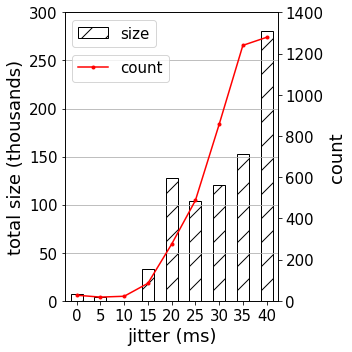

In [7]:
IGNORE_CACHE = False

deadlocks_df = from_cache_or_compute(
    f'{PREFIX}/deadlocks.parquet',
    lambda: get_deadlocks(throughput_df),
    ignore_cache=IGNORE_CACHE,
)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
deadlocks_df["deadlock_sz"] /= 1000
deadlocks_df.plot.bar(x="jitter", y="deadlock_sz", rot=0, ax=ax, legend=True, fill=False, hatch='/', label='size')
ax.legend(loc="upper left")
ax.set_xlabel("jitter (ms)")
ax.set_ylabel("total size (thousands)")
ax.set_ylim([0, 300])
ax.grid(axis='y')

ax2 = ax.twinx()
deadlocks_df.plot(x="jitter", y="deadlock_cnt", rot=0, ax=ax2, marker='.', color='red', label='count')
ax2.legend(loc="upper left", bbox_to_anchor=(0, 0.88))
ax2.set_ylabel("count")
ax2.set_ylim([0, 1400])

fig.tight_layout()
fig.savefig('output/jitter-deadlocks.pdf')


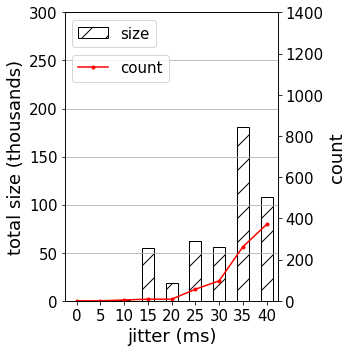

In [8]:
IGNORE_CACHE = False

deadlocks_overshoot10_df = from_cache_or_compute(
    f'{PREFIX_OVERSHOOT10}/deadlocks.parquet',
    lambda: get_deadlocks(throughput_overshoot10_df),
    ignore_cache=IGNORE_CACHE,
)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
deadlocks_overshoot10_df['deadlock_sz'] /= 1000
deadlocks_overshoot10_df.plot.bar(x="jitter", y="deadlock_sz", rot=0, ax=ax, legend=False, fill=False, hatch='/', label='size')
ax.legend(loc="upper left")
ax.set_xlabel("jitter (ms)")
ax.set_ylabel("total size (thousands)")
ax.set_ylim([0, 300])
ax.grid(axis='y')

ax2 = ax.twinx()
deadlocks_overshoot10_df.plot(x="jitter", y="deadlock_cnt", rot=0, ax=ax2, marker='.', color='red', label='count')
ax2.legend(loc="upper left", bbox_to_anchor=(0, 0.88))
ax2.set_ylabel("count")
ax2.set_ylim([0, 1400])

fig.tight_layout()
fig.savefig('output/jitter-deadlocks-overshoot10.pdf')

# Latency

In [9]:
IGNORE_CACHE = False

percentile_cols = [
    F.percentile_approx("latency", 0.5).alias("p50"),
    F.percentile_approx("latency", 0.90).alias("p90"),
    F.percentile_approx("latency", 0.95).alias("p95"),
    F.percentile_approx("latency", 0.99).alias("p99"),
]

latency_df = from_cache_or_compute(
    f'{PREFIX}/latency.parquet',
    lambda: latency(spark, index_df["prefix"])\
        .groupBy("prefix")\
        .agg(*percentile_cols)\
        .toPandas()\
        .merge(index_df, on="prefix")\
        .sort_values("jitter", key=lambda k: k.astype('int')),
    ignore_cache=IGNORE_CACHE,
)

latency_overshoot10_df = from_cache_or_compute(
    f'{PREFIX_OVERSHOOT10}/latency.parquet',
    lambda:  latency(spark, index_overshoot10_df["prefix"])\
        .groupBy("prefix")\
        .agg(*percentile_cols)\
        .toPandas()\
        .merge(index_overshoot10_df, on="prefix")\
        .sort_values("jitter", key=lambda k: k.astype('int')),
    ignore_cache=IGNORE_CACHE,
)

# Plot

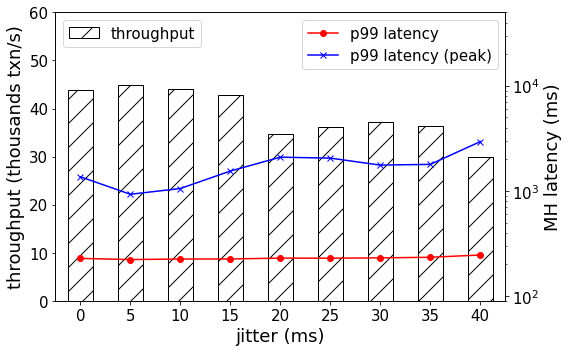

In [10]:
_, ax = plt.subplots(1, 1, figsize=(8, 5))

throughput_df.plot.bar(ax=ax, x="jitter", y="throughput", rot=0, fill=False, hatch='/')
ax.set_ylabel("throughput (thousands txn/s)")
ax.set_xlabel("jitter (ms)")
ax.set_ylim((0, 60))
ax.legend(loc="upper left")
ax2 = ax.twinx()

latency_200_df = latency_df[latency_df['clients'] == 200]
latency_3000_df = latency_df[latency_df['clients'] == 3000]

# latency_200_df.plot(ax=ax2, x="jitter", y="p50", label='p50 latency', linestyle='dotted', marker='.', color="red")
latency_200_df.plot(ax=ax2, x="jitter", y="p99", label='p99 latency', marker='o', color="red")
# latency_3000_df.plot(ax=ax2, x="jitter", y="p50", label='p50 latency', linestyle='dotted', marker='x', color="blue")
latency_3000_df.plot(ax=ax2, x="jitter", y="p99", label='p99 latency (peak)', marker='x', color="blue")
ax2.set_ylabel("MH latency (ms)")
ax2.set_yscale('log')
ax2.set_ylim((90, 50000))
ax2.legend(loc="upper right", ncol=1)
 
plt.tight_layout()
plt.savefig("output/jitter.pdf")

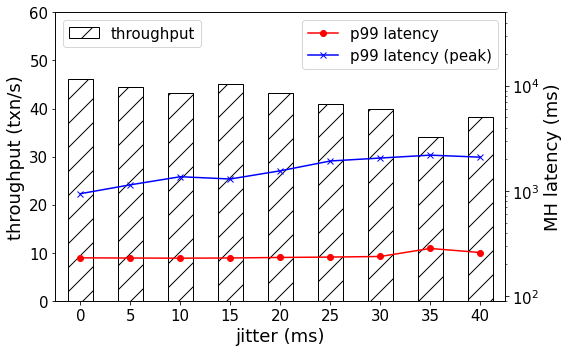

In [11]:
_, ax = plt.subplots(1, 1, figsize=(8, 5))

throughput_overshoot10_df.plot.bar(ax=ax, x="jitter", y="throughput", rot=0, fill=False, hatch='/')
ax.set_ylabel("throughput (txn/s)")
ax.set_xlabel("jitter (ms)")
ax.set_ylim((0, 60))
ax.legend(loc="upper left")
ax2 = ax.twinx()

latency_200_df = latency_overshoot10_df[latency_overshoot10_df['clients'] == 200]
latency_3000_df = latency_overshoot10_df[latency_overshoot10_df['clients'] == 3000]

# latency_200_df.plot(ax=ax2, x="jitter", y="p50", label='p50 latency', linestyle='dotted', marker='.', color="red")
latency_200_df.plot(ax=ax2, x="jitter", y="p99", label='p99 latency', marker='o', color="red")
# latency_3000_df.plot(ax=ax2, x="jitter", y="p50", label='p50 latency', linestyle='dotted', marker='x', color="blue")
latency_3000_df.plot(ax=ax2, x="jitter", y="p99", label='p99 latency (peak)', marker='x', color="blue")
ax2.set_ylabel("MH latency (ms)")
ax2.set_yscale('log')
ax2.set_ylim((90, 50000))
ax2.legend(loc="upper right", ncol=1)
 
plt.tight_layout()
plt.savefig("output/jitter-overshoot10.pdf")